In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
tf.random.set_seed(42)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 400

def create_data_generators():
    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Test data generator (only rescaling)
    test_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Replace 'path_to_data' with your actual data path
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/400birds/400BirdSpecies/train',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    
    validation_generator = val_datagen.flow_from_directory(
        '/kaggle/input/400birds/400BirdSpecies/valid',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        '/kaggle/input/400birds/400BirdSpecies/test',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

def create_model():
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

def create_callbacks():
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    return [checkpoint, early_stopping, reduce_lr]


In [2]:
# Add these imports to the previous ones
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model

def calculate_class_weights(train_generator):
    """Calculate class weights to handle class imbalance"""
    # Get all labels from the generator
    labels = []
    steps = len(train_generator)
    for i in range(steps):
        _, y = train_generator[i]
        labels.extend(np.argmax(y, axis=1))
        
    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    
    return dict(enumerate(class_weights))

def create_model_with_unfreezing():
    """Create model with gradual unfreezing capability"""
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Initially freeze the base model
    base_model.trainable = False
    
    # Create the model
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model, base_model

def train_model():
    # Create data generators
    train_generator, validation_generator, test_generator = create_data_generators()
    
    # Calculate class weights
    class_weights = calculate_class_weights(train_generator)
    
    # Create model
    model, base_model = create_model_with_unfreezing()
    
    # Training history storage
    all_history = []
    
    # Phase 1: Train only the top layers
    print("Phase 1: Training top layers...")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history1 = model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=create_callbacks(),
        class_weight=class_weights
    )
    all_history.append(history1)
    
    # Phase 2: Unfreeze and train the last few Xception blocks
    print("Phase 2: Fine-tuning last Xception blocks...")
    for layer in base_model.layers[-30:]:
        layer.trainable = True
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history2 = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=create_callbacks(),
        class_weight=class_weights
    )
    all_history.append(history2)
    
    # Phase 3: Unfreeze all layers
    print("Phase 3: Fine-tuning all layers...")
    base_model.trainable = True
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history3 = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        callbacks=create_callbacks(),
        class_weight=class_weights
    )
    all_history.append(history3)
    
    return model, all_history, test_generator

def plot_training_history(all_history):
    """Plot training metrics"""
    # Combine histories
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    
    for history in all_history:
        acc.extend(history.history['accuracy'])
        val_acc.extend(history.history['val_accuracy'])
        loss.extend(history.history['loss'])
        val_loss.extend(history.history['val_loss'])
    
    epochs = range(1, len(acc) + 1)
    
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_generator):
    """Evaluate model and display metrics"""
    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    
    # Calculate metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix (for top N classes due to large number of classes)
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix (Top 20 Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def analyze_errors(model, test_generator, num_samples=5):
    """Show examples of correct and incorrect predictions"""
    predictions = model.predict(test_generator)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    
    # Get class labels
    class_labels = {v: k for k, v in test_generator.class_indices.items()}
    
    # Find correct and incorrect predictions
    correct_indices = np.where(pred_classes == true_classes)[0]
    incorrect_indices = np.where(pred_classes != true_classes)[0]
    
    # Plot some correct predictions
    plt.figure(figsize=(15, 5))
    plt.suptitle('Correct Predictions', y=1.05)
    for i in range(num_samples):
        if i < len(correct_indices):
            idx = correct_indices[i]
            img = test_generator[idx // BATCH_SIZE][0][idx % BATCH_SIZE]
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f'True: {class_labels[true_classes[idx]]}')
            plt.axis('off')
    plt.show()
    
    # Plot some incorrect predictions
    plt.figure(figsize=(15, 5))
    plt.suptitle('Incorrect Predictions', y=1.05)
    for i in range(num_samples):
        if i < len(incorrect_indices):
            idx = incorrect_indices[i]
            img = test_generator[idx // BATCH_SIZE][0][idx % BATCH_SIZE]
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(f'True: {class_labels[true_classes[idx]]}\nPred: {class_labels[pred_classes[idx]]}')
            plt.axis('off')
    plt.show()


Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 1: Training top layers...
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733906852.659185     111 service.cc:145] XLA service 0x7969180031d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733906852.659241     111 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/1825 ━━━━━━━━━━━━━━━━━━━━ 2:19 77ms/step - accuracy: 0.0000e+00 - loss: 6.4710  

I0000 00:00:1733906861.240096     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.2252 - loss: 3.9043
Epoch 1: val_accuracy improved from -inf to 0.72000, saving model to best_model.keras
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 700s 375ms/step - accuracy: 0.2253 - loss: 3.9038 - val_accuracy: 0.7200 - val_loss: 1.0213 - learning_rate: 0.0010
Epoch 2/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.4722 - loss: 2.1437
Epoch 2: val_accuracy improved from 0.72000 to 0.75600, saving model to best_model.keras
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 661s 361ms/step - accuracy: 0.4722 - loss: 2.1437 - val_accuracy: 0.7560 - val_loss: 0.8521 - learning_rate: 0.0010
Epoch 3/10
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5187 - loss: 1.9227
Epoch 3: val_accuracy improved from 0.75600 to 0.79350, saving model to best_model.keras
1825/1825 ━━━━━━━━━━━━━━━━━━━━ 655s 357ms/step - accuracy: 0.5187 - loss: 1.9227 - val_accuracy: 0.7935 - val_loss: 0.7126 - learning_rate: 0.0010
Epoch 4/10
1825/1825 ━━━━━━━━━━━━━━━

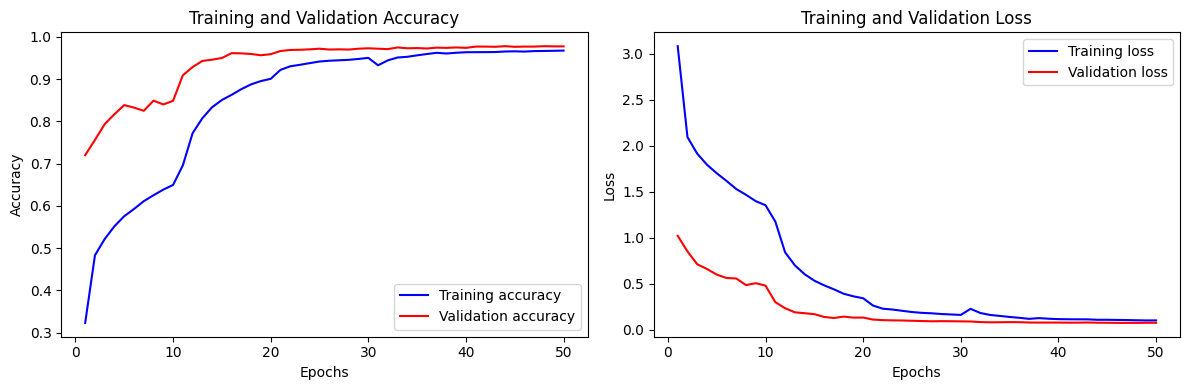

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16   

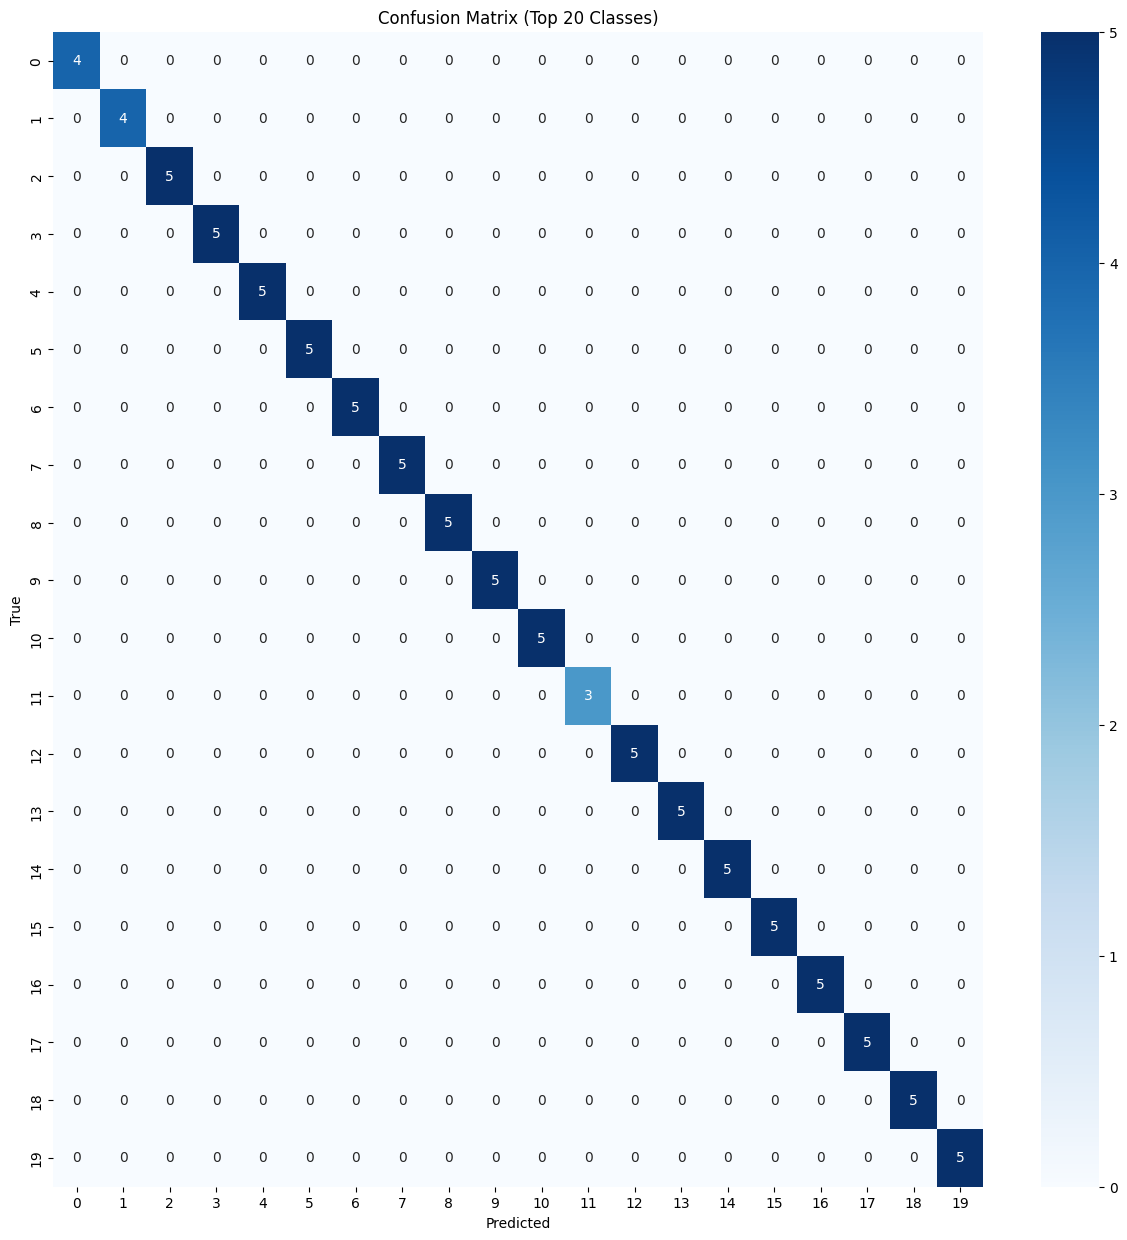

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


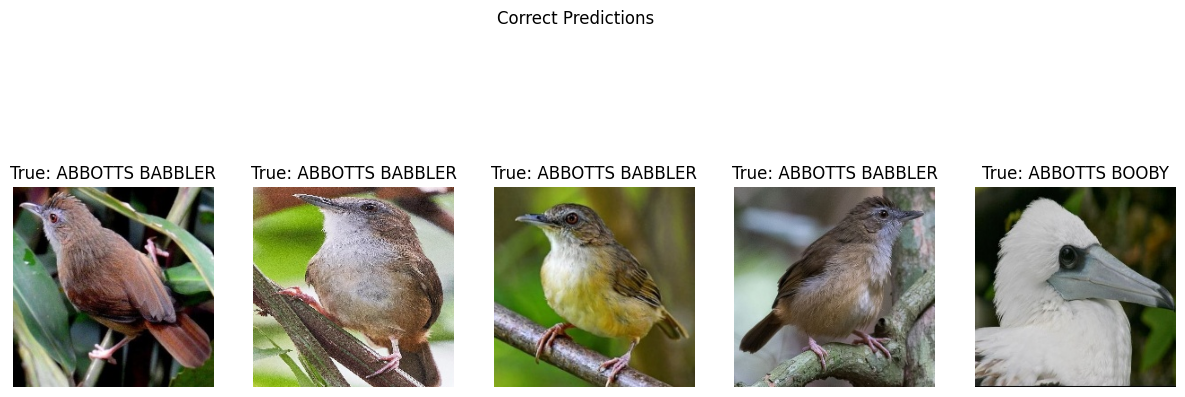

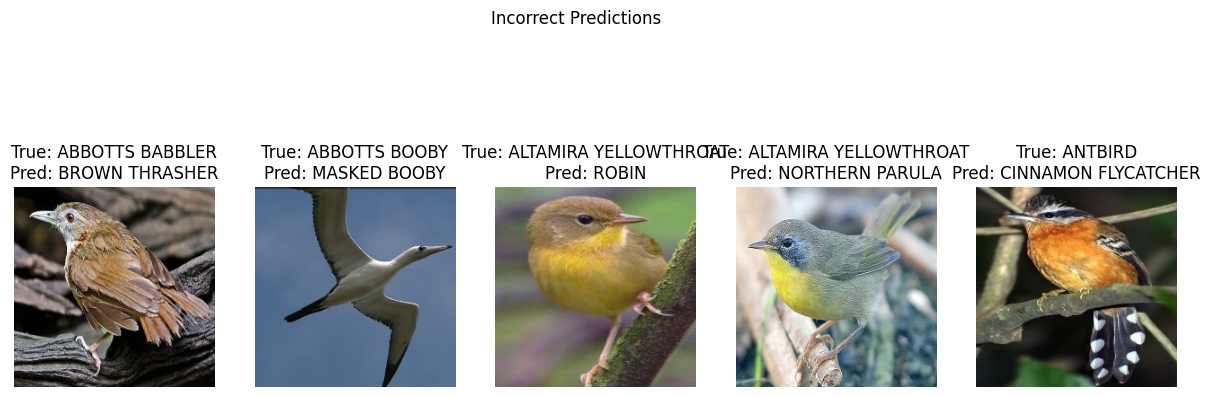

In [3]:
# Train the model
model, history, test_generator = train_model()

# Plot training history
plot_training_history(history)

# Evaluate model
evaluate_model(model, test_generator)

# Analyze errors
analyze_errors(model, test_generator)